## Noah's Work Space

# CaBI Data Downloading and Simple Cleaning

The first seciton uses a chrome browser to download all the zip files from CaBI site to a local directory. Then unpacks all the zip files to the same directory. Within these files is the trip history by bike, including starting and ending station, duration of the trip, member type, date/time of trip.

The second section downloads a json page of all the station locations and their region ID. Then is downloads another json page that maps the region IDs to the DMV regions as defined by CaBi.

The third section preprocess the raw csv files
    -extracts the day of the week, hour, and day for each ride
    -megres the region codes into the trip data. 
    -converts duration to minutes from miliseconds
    -stacks the qarterly CSVs into years




In [78]:
# Load Cabi Trip Data as Data Frame

from datetime import date
import calendar
import pandas as pd
import glob2
import re
import time
import os
import sys

TIMESTR = time.strftime("%Y%m%d_%H%M%S")

files = glob2.glob('C:/Users/Noah/Bikeshare-DC_Old/CaBi/*.csv')

Final_Daily_Roll_Up = pd.DataFrame()
Final_Daily_Rides = pd.DataFrame()

FILE_LIST = []
FILE_LIST_all = []

print(files)
for file in files:
     # Total Unique Bikes Used
    print(file)
    trip_df = pd.read_csv(file)
    start_datetime = pd.to_datetime(trip_df['Start date'])
    trip_df['start_date'] = start_datetime.map(lambda x: x.date())
    trip_df['month'] = start_datetime.dt.month
    trip_df['year'] = start_datetime.dt.year
    bikes_count = trip_df.groupby('start_date')['Bike number'].nunique()
    bikes_count = bikes_count.reset_index()
    bikes_count = pd.DataFrame(bikes_count.to_records())
    bikes_count.set_index('start_date', inplace=True)
    bikes_count = bikes_count[['Bike number']].rename(columns={'Bike number': 'CaBi_B_All'})

    # Unique Bikes Used by Region Start and End
    bikes_by_regions_count = trip_df.groupby(['start_date', 'region_start_end'])['Bike number'].nunique().unstack()
    bikes_by_regions_count.columns = [''.join(col).strip() for col in bikes_by_regions_count.columns.values]
    bikes_by_regions_count = bikes_by_regions_count.add_suffix('_Uni_PD').add_prefix('CaBi_')

      
    # Total Trips - Average Duration per Day
    trips_count = trip_df.groupby(['start_date','year','month','Weekday'])['Minutes'].agg(['mean','count']) \
        .rename(columns={'mean': 'Mean_Time', 'count': 'Count_Trip'})
    trips_count = trips_count.add_suffix('_Per_Day').add_prefix('CaBi_').reset_index()
    trips_count.set_index('start_date', inplace=True)
    # Total Trips - Average Duration per Day
    trip_df['start_hour'] = trip_df['start_hour'].apply(str)
    trips_hour = trip_df.groupby(['start_date','start_hour'])['Minutes'].agg(['mean','count']) \
        .rename(columns={'mean': 'Mean_Time', 'count': 'Count_Trip'}).unstack()
    trips_hour.columns = ['_'.join(col).strip() for col in trips_hour.columns.values]
    trips_hour = trips_hour.add_suffix('_Hr_Per_Day').add_prefix('CaBi_').reset_index()
    trips_hour.set_index('start_date', inplace=True)
    
    # Total Trip per Day by Region Start and End
    trips_by_member = trip_df.groupby(['start_date', 'Member type'])['Minutes'].agg(['mean','count']) \
        .rename(columns={'mean': 'Mean_Time', 'count': 'Count_Trip'}).unstack()
    trips_by_member.columns = ['_'.join(col).strip() for col in trips_by_member.columns.values]
    trips_by_member = trips_by_member.add_suffix('_Per_Day').add_prefix('CaBi_').reset_index()
    trips_by_member.set_index('start_date', inplace=True)
    # Total Trips by Member Type
    trips_by_regions = trip_df.groupby(['start_date', 'region_start_end'])['Minutes'].agg(['mean','count']) \
    .rename(columns={'mean': 'Mean_Time', 'count': 'Count_Trip'}).unstack()
    trips_by_regions.columns = ['_'.join(col).strip() for col in trips_by_regions.columns.values]
    trips_by_regions = trips_by_regions.add_suffix('_Per_Day').add_prefix('CaBi_').reset_index()
    trips_by_regions.set_index('start_date', inplace=True)
    # Total Trips by Region and Member Type
    trips_by_reg_member = trip_df.groupby(['start_date', 'region_start_end', 'Member type'])['Minutes'].agg(['mean','count']) \
        .rename(columns={'mean': 'Mean_Time', 'count': 'Count_Trip'}).unstack().unstack()
    trips_by_reg_member.columns = ['_'.join(col).strip() for col in trips_by_reg_member.columns.values]
    trips_by_reg_member = trips_by_reg_member.add_suffix('_Per_Day').add_prefix('CaBi_').reset_index()
    trips_by_reg_member.set_index('start_date', inplace=True)
    check = [bikes_count, bikes_by_regions_count, trips_count, trips_by_regions, trips_by_member]
    bikes_all = pd.concat([bikes_count, bikes_by_regions_count, trips_count, trips_by_regions, trips_by_member, trips_hour, trips_by_reg_member], axis=1)
    # Fill all na as zeros
    bikes_all.fillna(value=0, inplace=True)
    Stats = bikes_all.groupby(['month'])['CaBi_Count_Trip_Per_Day','CaBi_Mean_Time_Per_Day'].describe()
    print(Stats)
    Final_Daily_Rides = Final_Daily_Rides.append(bikes_all)
    
filename = "CABI_Daily_Trips" + TIMESTR + ".csv"
filepath = os.path.join("C:/Users/Noah/Bikeshare-DC_Old", filename)
Final_Daily_Rides.to_csv(filepath, index=True, index_label='start_date')
    


['C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2010-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2011-q1_2011-q2_2011-q3_2011-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2012-q1_2012-q2_2012-q3_2012-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2013-q1_2013-q2_2013-q3_2013-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2014-q1_2014-q2_2014-q3_2014-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2015-q1_2015-q2_2015-q3_2015-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2016-q1_2016-q2_2016-q3_2016-q4.csv', 'C:/Users/Noah/Bikeshare-DC_Old/CaBi\\CABI_Daily_Trips_20180310_120659_2017-q1_2017-q2_2017-q3_2017-q4.csv']
C:/Users/Noah/Bikeshare-DC_Old/CaBi\CABI_Daily_Trips_20180310_120659_2010-q4.csv
      CaBi_Count_Trip_Per_Day                                         

      CaBi_Count_Trip_Per_Day                                             \
                        count         mean          std     min      25%   
month                                                                      
1                        31.0  4034.709677  1075.604642  1965.0  3089.50   
2                        28.0  3934.857143   957.521790  2450.0  3293.50   
3                        31.0  5078.741935  1664.026482  1126.0  4095.50   
4                        30.0  7883.833333  1676.925987  4293.0  6464.25   
5                        31.0  8081.677419  1234.766844  4425.0  7470.50   
6                        30.0  8461.066667  1875.088925  2479.0  7297.50   
7                        31.0  8648.290323  1052.308801  5728.0  8053.00   
8                        31.0  9318.354839  1112.635446  5754.0  8919.50   
9                        30.0  9400.433333   925.466245  6840.0  9088.50   
10                       31.0  8217.387097  2128.557691  1777.0  7879.50   
11          

C:\Users\Noah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3,5,18,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


      CaBi_Count_Trip_Per_Day                                               \
                        count          mean          std     min       25%   
month                                                                        
1                        27.0   4565.666667  1625.242609   528.0   3310.00   
2                        29.0   5023.103448  1946.124452   501.0   4244.00   
3                        31.0   9145.741935  2883.719299  3227.0   6751.00   
4                        30.0   9518.800000  2348.261696  4069.0   8290.75   
5                        31.0   9314.516129  2856.402573  2851.0   8138.50   
6                        30.0  12271.700000  1489.080534  8519.0  11853.75   
7                        31.0  11822.387097  1639.904157  7601.0  10998.00   
8                        31.0  11528.096774  1534.245794  7252.0  11249.50   
9                        30.0  11481.600000  1792.537108  5889.0  11077.50   
10                       31.0  11074.225806  1810.945880  5127.0

In [12]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import time

TIMESTR = time.strftime("%Y%m%d_%H%M%S")
def open_drive():
    gauth = GoogleAuth()
    gauth.LocalWebserverAuth()  # Creates local webserver and auto handles authentication.
    drive = GoogleDrive(gauth)
    return drive
def push_to_drive(custom_title,location):
    file1 = drive.CreateFile({'title':custom_title,
        "parents": [{"kind": "drive#fileLink","id": '1VzEbxzEhExC3doLonshh_6Xjcghz6OHt'}]})# Create GoogleDriveFile instance with title 'Text2.txt'.
    file1.SetContentFile(location)  
    file1.Upload()


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=496206805628-tg936o9a8g2km3uqqalfcd7go7c7ebio.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


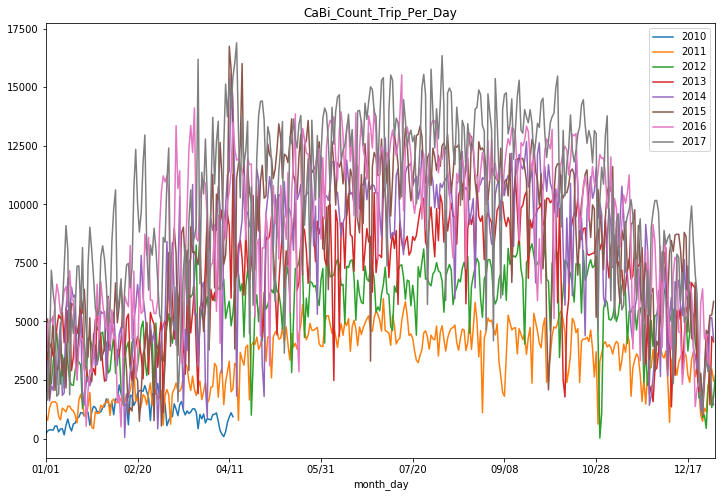

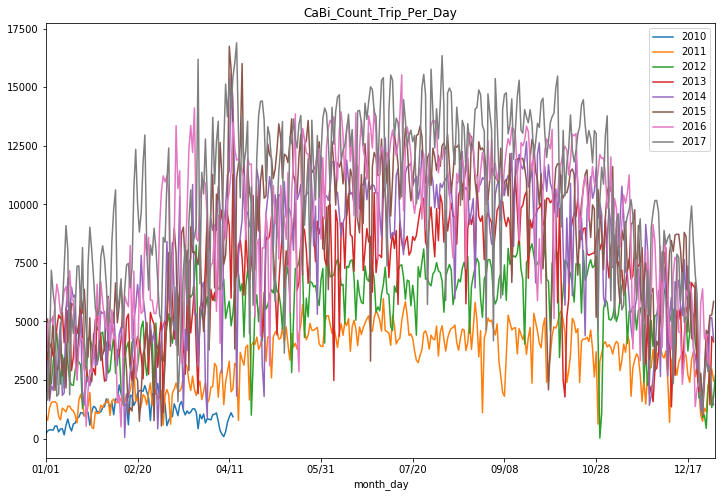

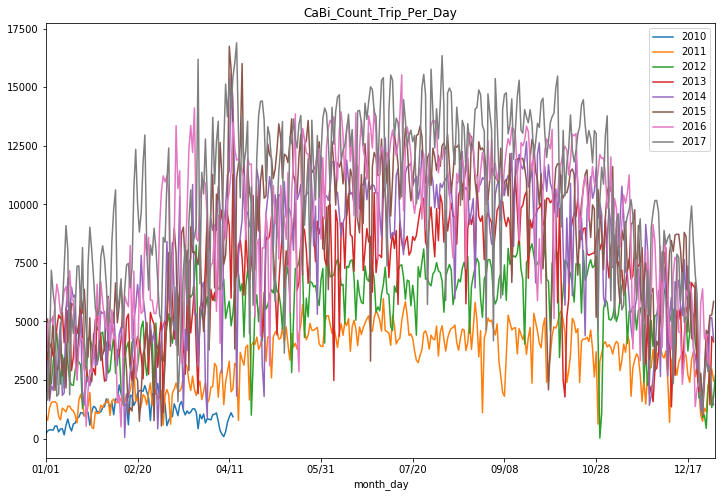

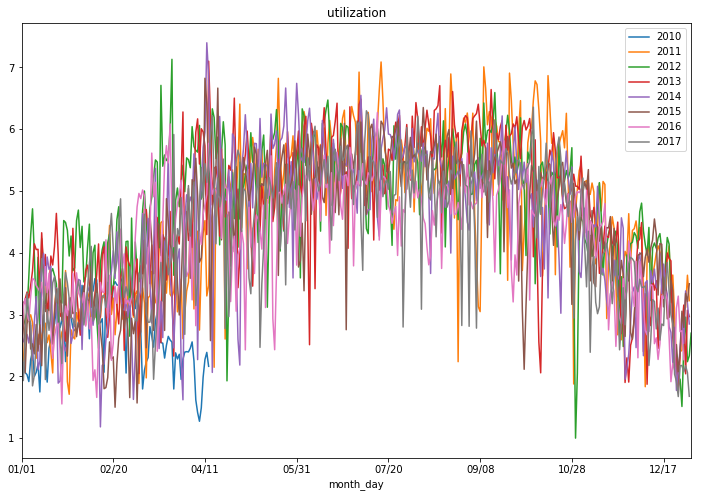

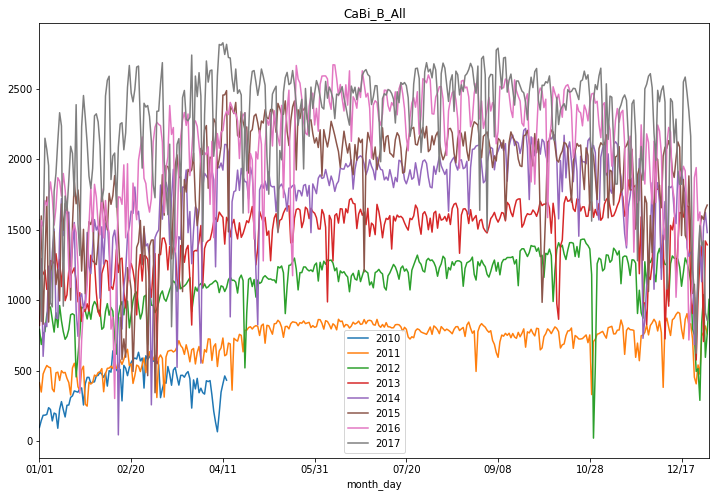

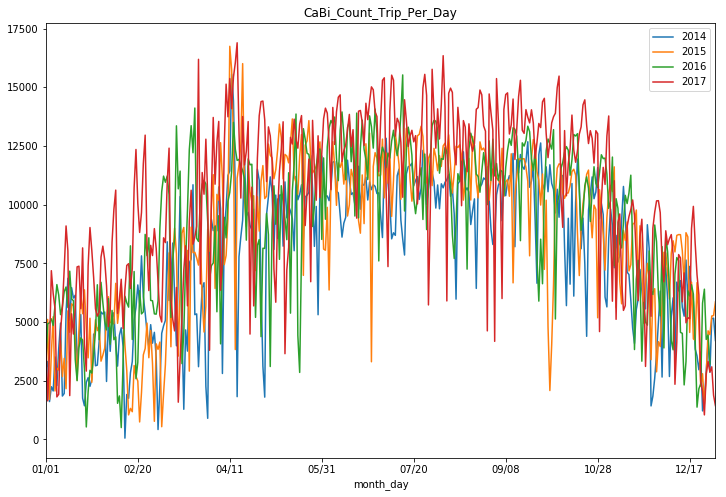

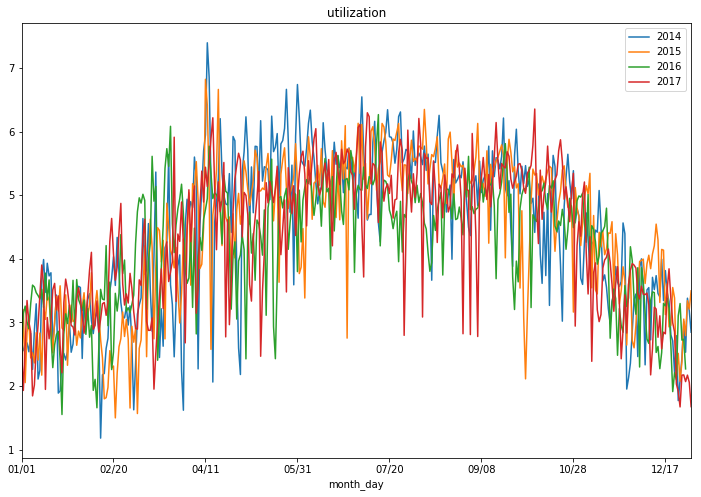

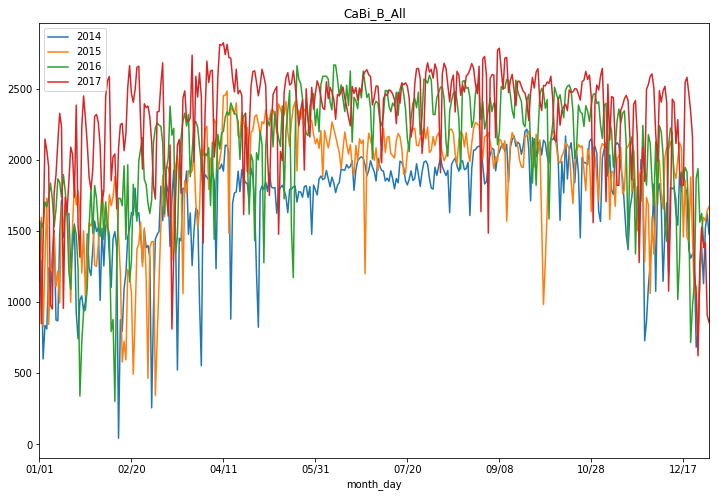

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180310_205606.csv", parse_dates=column)
graph_data['month_day'] =  graph_data['start_date'].dt.strftime('%m') +'/' + graph_data['start_date'].dt.strftime('%d')
graph_data['utilization'] = graph_data['CaBi_Count_Trip_Per_Day']/ graph_data['CaBi_B_All']
metrics =['CaBi_Count_Trip_Per_Day' ,'utilization', 'CaBi_B_All']


drive = open_drive()  
for mets in metrics:
    fig, ax = plt.subplots()
    for key, grp in graph_data.groupby(['year']):
         ax = grp.plot(ax=ax, kind='line', x='month_day', y=mets, label=key, title=mets, figsize=(12,8))
    plt.legend(loc='best')
    filepath = 'C:/Users/Noah/Bikeshare-DC_Old/Today/Overall' + str(mets) +TIMESTR+ '.png'
    title = 'Overall' + str(mets)
    plt.savefig(filepath)
    push_to_drive(title,filepath)
    plt.show()
    
graph_14_17 = graph_data[graph_data['year']>=2014]    
for mets in metrics:
    fig, ax = plt.subplots()
    for key, grp in graph_14_17.groupby(['year']):
         ax = grp.plot(ax=ax, kind='line', x='month_day', y=mets, label=key, title=mets, figsize=(12,8))
    plt.legend(loc='best')
    filepath = 'C:/Users/Noah/Bikeshare-DC_Old/14-17' + str(mets) + TIMESTR+ '.png'
    plt.savefig(filepath)
    plt.show()
    
        

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=496206805628-tg936o9a8g2km3uqqalfcd7go7c7ebio.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


C:\Users\Noah\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


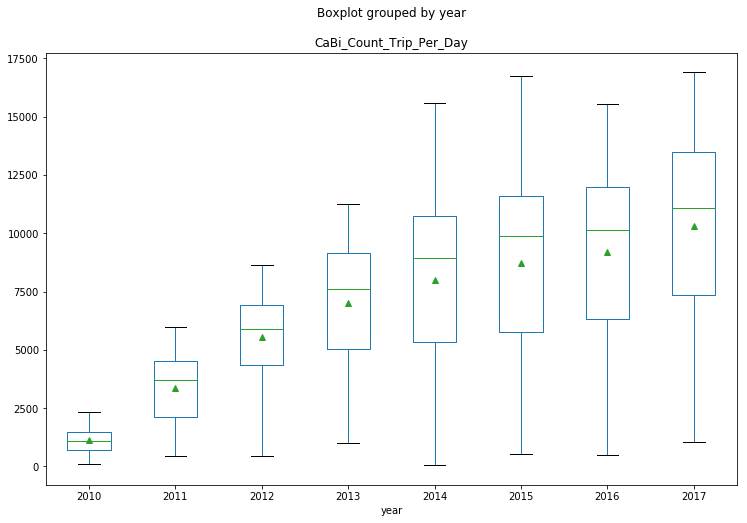

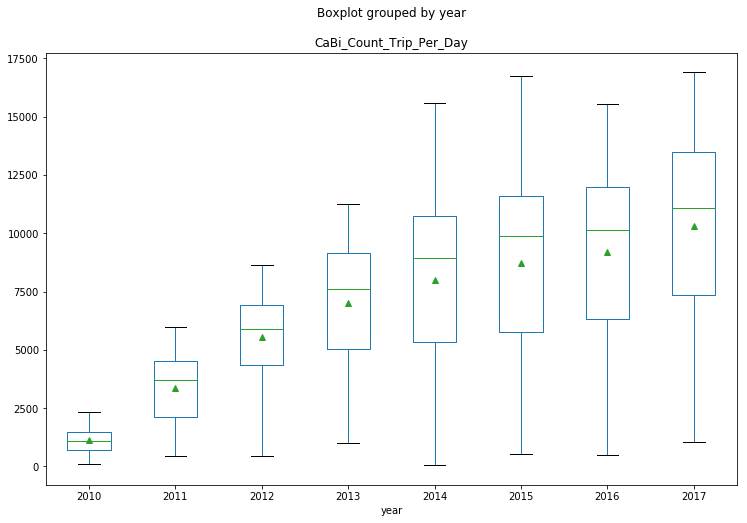

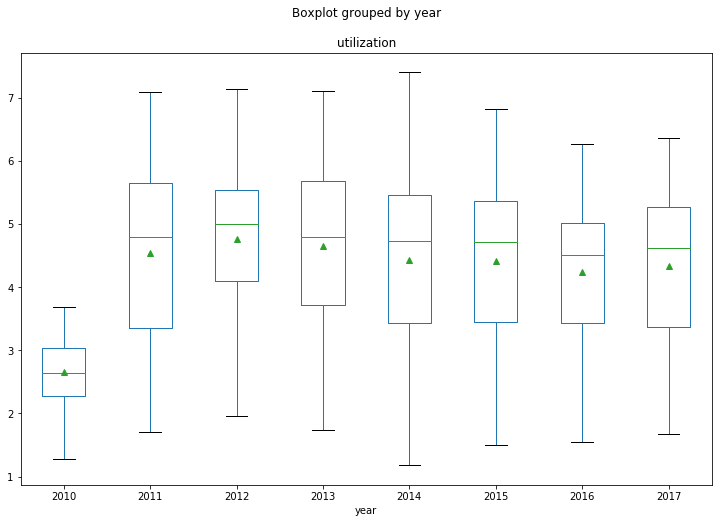

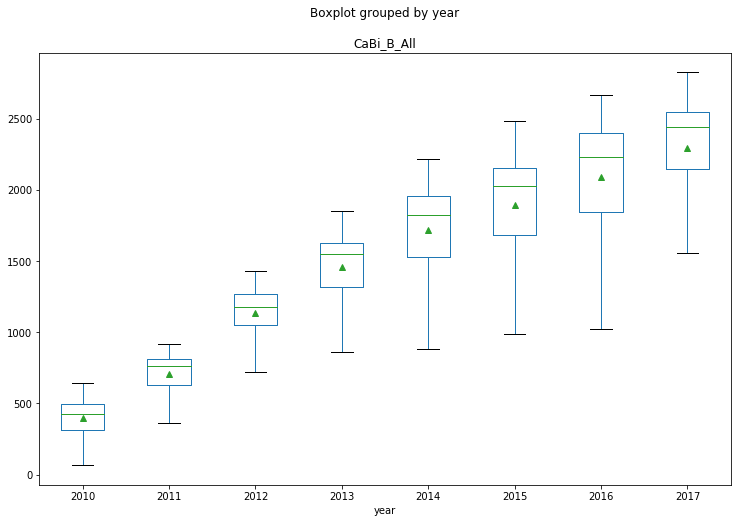

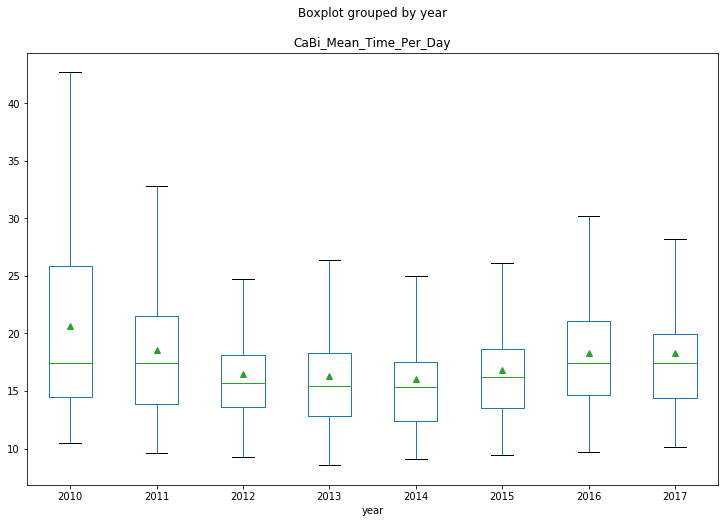

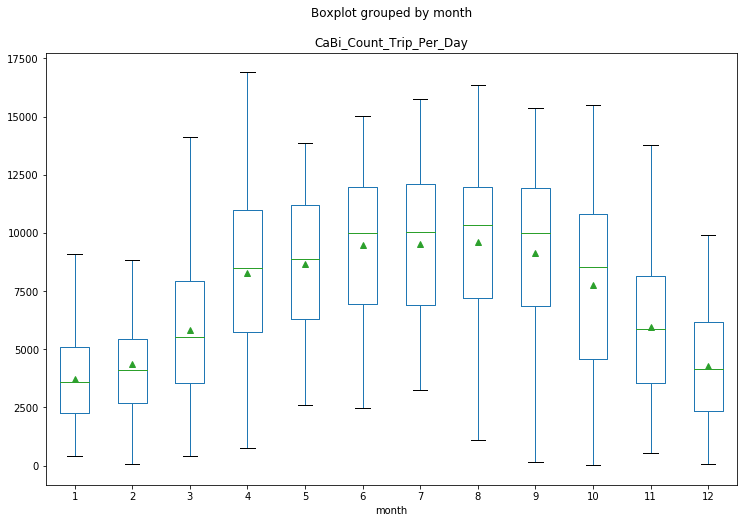

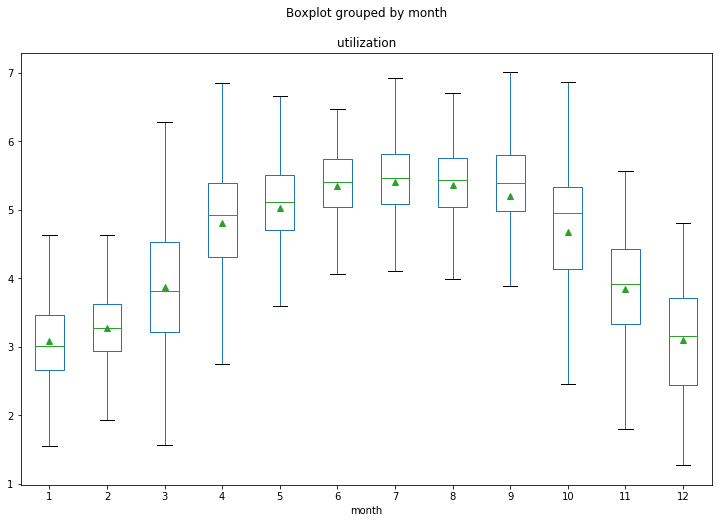

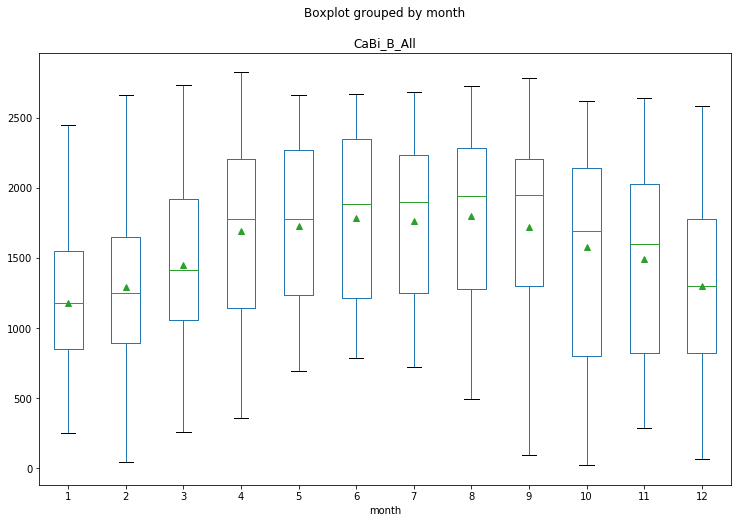

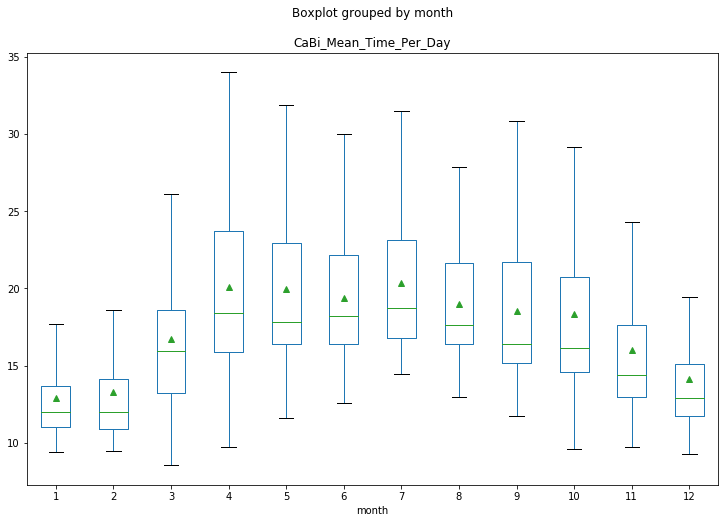

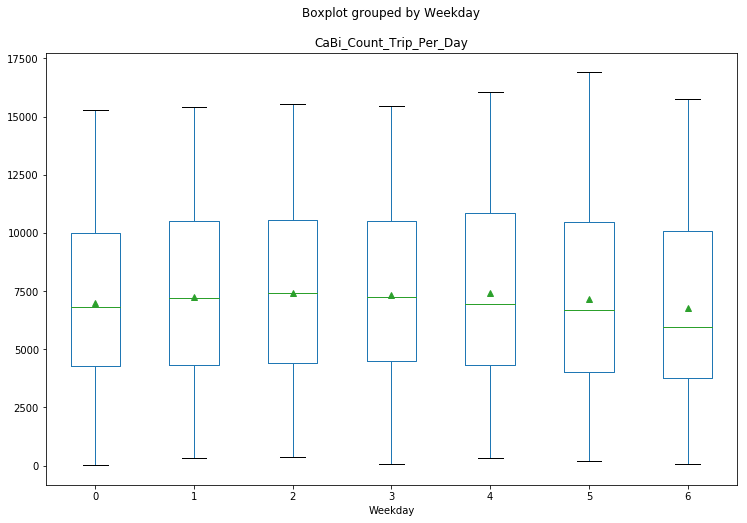

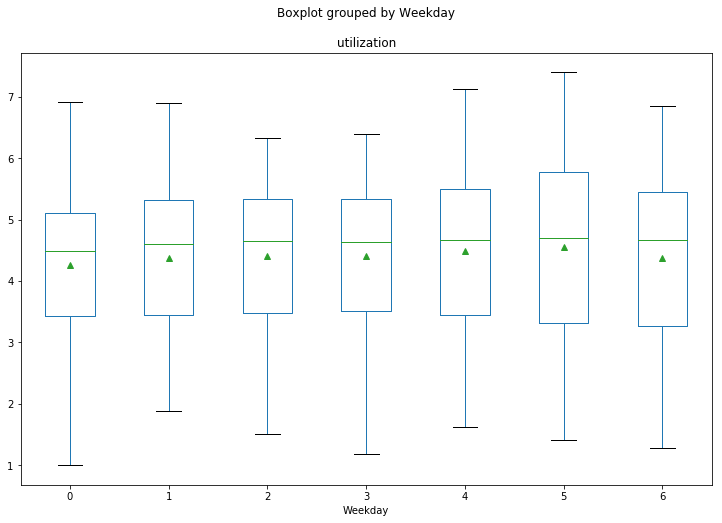

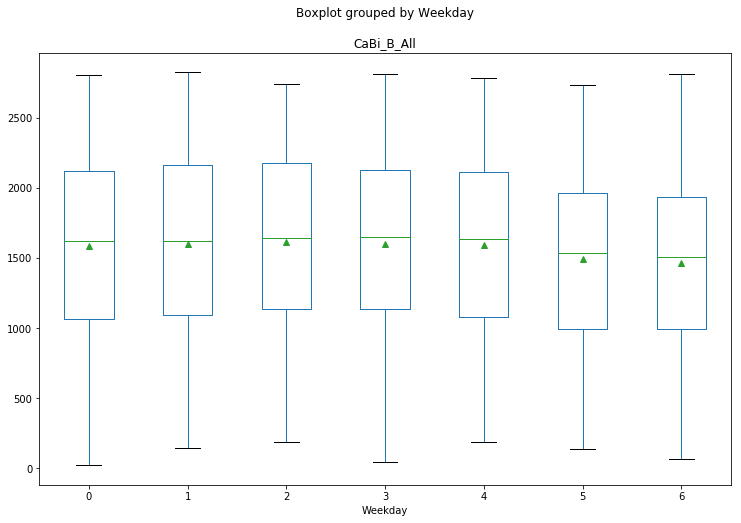

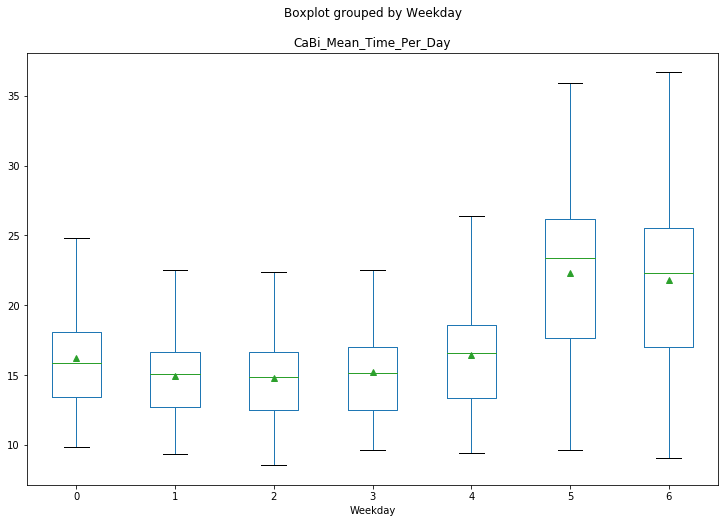

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

drive = open_drive()
column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180310_205606.csv", parse_dates=column)
graph_data['month_day'] =  graph_data['start_date'].dt.strftime('%m') +'/' + graph_data['start_date'].dt.strftime('%d')
graph_data['utilization'] = graph_data['CaBi_Count_Trip_Per_Day']/ graph_data['CaBi_B_All']

metrics =['CaBi_Count_Trip_Per_Day' ,'utilization', 'CaBi_B_All', 'CaBi_Mean_Time_Per_Day']


lists = ['year','month', 'Weekday']    
for over in lists:    
    for mets in metrics:
            graph_data.boxplot(column=mets, by=over,showfliers=False, grid=False, return_type='axes', figsize=(12,8), showmeans=True)
            plt.legend(loc='best')
            filepath = 'C:/Users/Noah/Bikeshare-DC_Old//Today/Box' +over + mets + TIMESTR + '.png'
            title = over + '_' + mets + '_' + TIMESTR
            plt.savefig(filepath)
            push_to_drive(title,filepath)
            plt.show()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=496206805628-tg936o9a8g2km3uqqalfcd7go7c7ebio.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


C:\Users\Noah\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


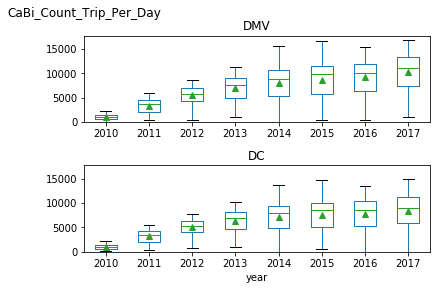

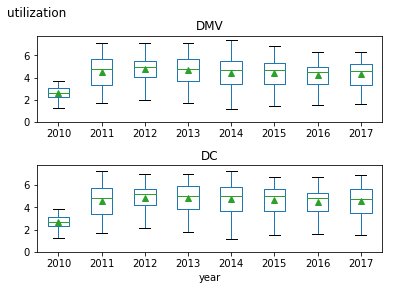

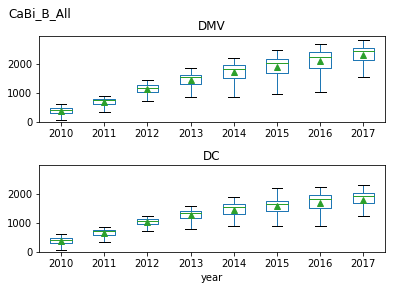

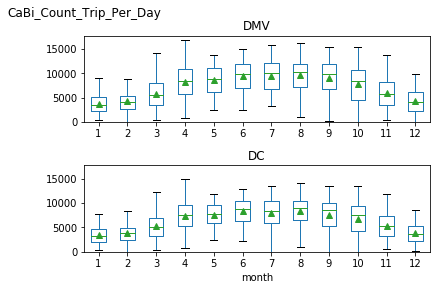

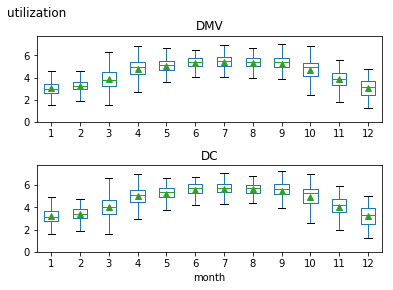

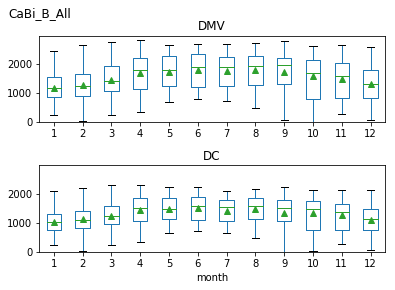

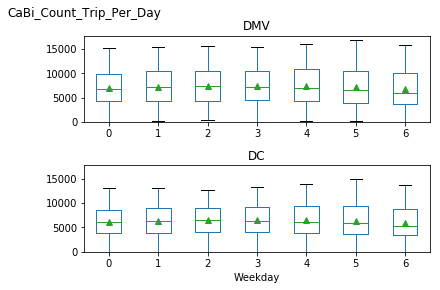

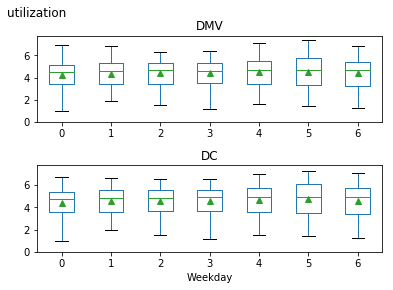

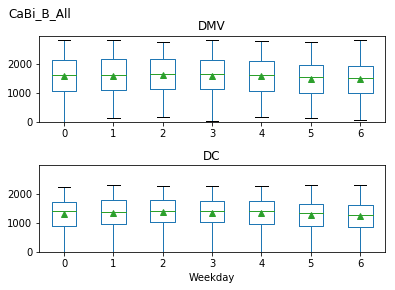

In [16]:
## Stacked Total and DC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180310_205606.csv", parse_dates=column)
graph_data['month_day'] =  graph_data['start_date'].dt.strftime('%m') +'/' + graph_data['start_date'].dt.strftime('%d')
graph_data['utilization'] = graph_data['CaBi_Count_Trip_Per_Day']/ graph_data['CaBi_B_All']
graph_data['utilization_WDC_to_WDC'] = graph_data['CaBi_Count_Trip_WDC_to_WDC_Per_Day']/ graph_data['CaBi_WDC_to_WDC_Uni_PD']
metrics_dc =['CaBi_Count_Trip_WDC_to_WDC_Per_Day' ,'utilization_WDC_to_WDC', 'CaBi_WDC_to_WDC_Uni_PD']
metrics =['CaBi_Count_Trip_Per_Day' ,'utilization', 'CaBi_B_All']

lists = ['year','month', 'Weekday']
drive = open_drive()
for over in lists:    
    for x, y in zip(metrics, metrics_dc):
            maximum = graph_data[x].max()*.05 + graph_data[x].max()
            fig = plt.figure()
            ax1 = fig.add_subplot(2, 1, 1)
            ax1.set_ylim(0,maximum)
            ax2 = fig.add_subplot(2, 1, 2)
            ax2.set_ylim(0,maximum)
            graph_data.boxplot(column=x, by=over,showfliers=False, grid=False, ax=ax1, return_type='axes', figsize=(12,8), showmeans=True)
            graph_data.boxplot(column=y, by=over,showfliers=False, grid=False, ax=ax2, return_type='axes', figsize=(12,8), showmeans=True)
            ax1.set_title('DMV')
            ax1.set_xlabel('')
            ax2.set_title('DC')
            plt.legend(loc='best')
            plt.suptitle(x, x=.1, y=1)
            fig.subplots_adjust(hspace=.5)
            title = over + '_' + x +'_' + y + '_' + TIMESTR
            filepath = 'C:/Users/Noah/Bikeshare-DC_Old//Tonight/Box' +over + x +y + TIMESTR+ '.png'
            plt.savefig(filepath)
            push_to_drive(title,filepath)
            plt.show()

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=496206805628-tg936o9a8g2km3uqqalfcd7go7c7ebio.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


C:\Users\Noah\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


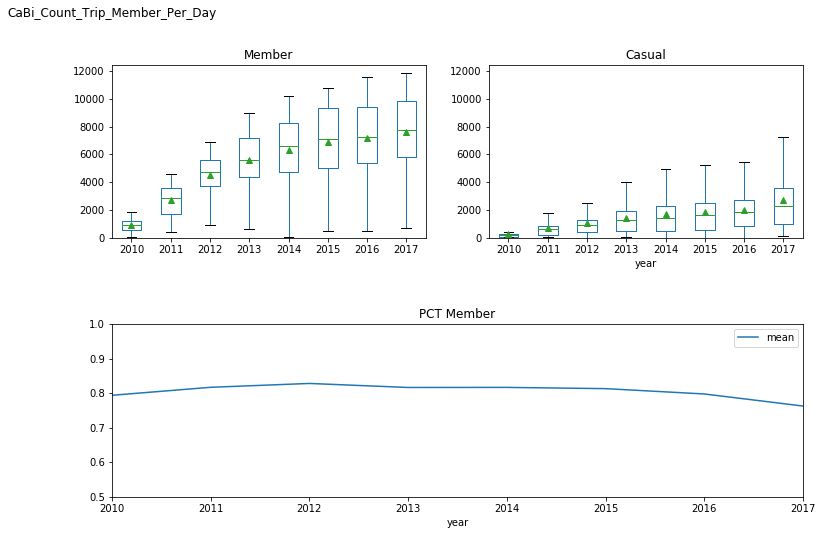

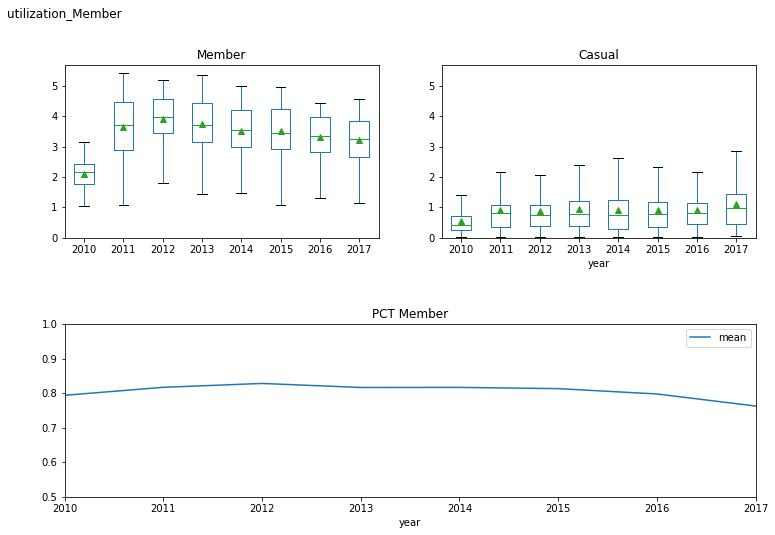

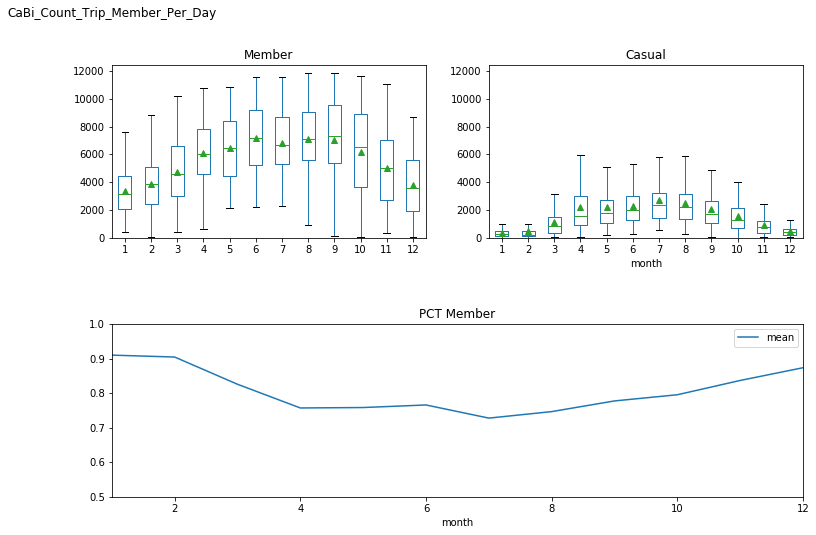

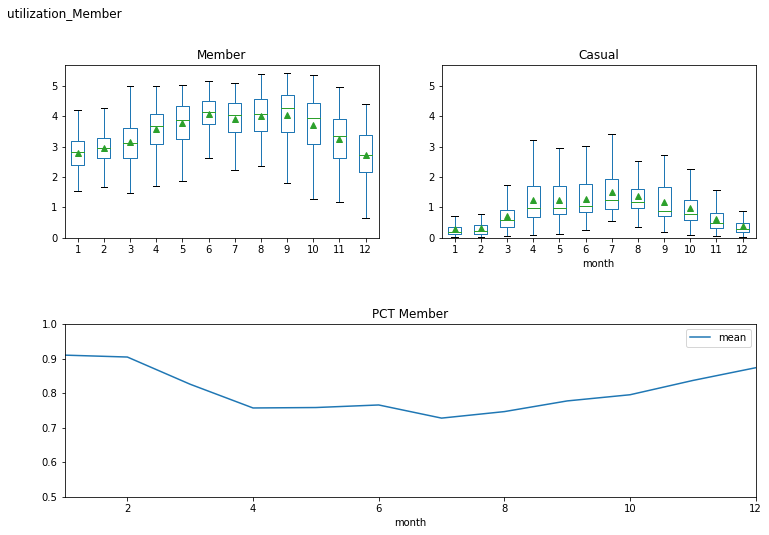

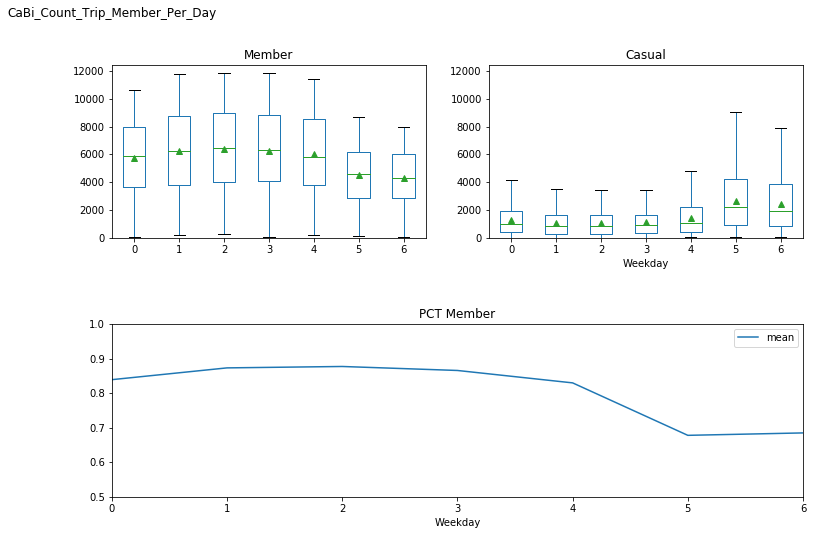

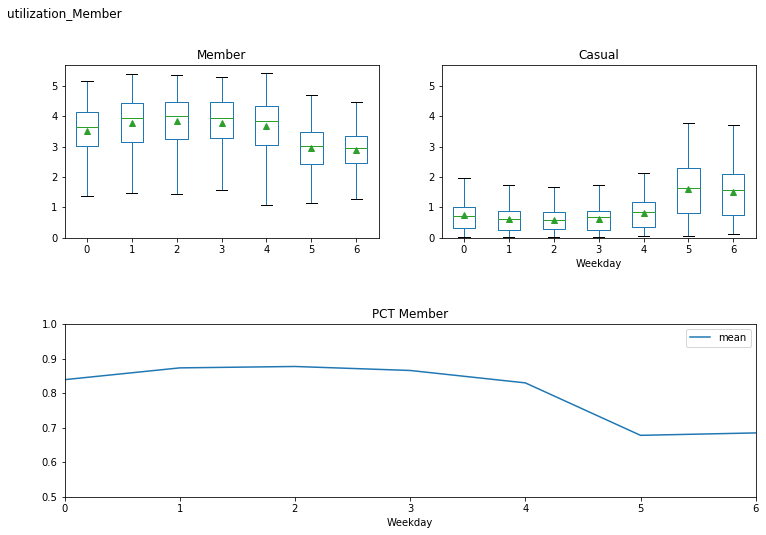

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180319_184536.csv", parse_dates=column)
graph_data['month_day'] =  graph_data['start_date'].dt.strftime('%m') +'/' + graph_data['start_date'].dt.strftime('%d')
graph_data['utilization_Casual'] = graph_data['CaBi_Count_Trip_Casual_Per_Day']/ graph_data['CaBi_B_All']
graph_data['utilization_Member'] = graph_data['CaBi_Count_Trip_Member_Per_Day']/ graph_data['CaBi_B_All']
graph_data['Pct Member'] = graph_data['CaBi_Count_Trip_Member_Per_Day'] /  graph_data['CaBi_Count_Trip_Per_Day']
metrics_dc =['CaBi_Count_Trip_Casual_Per_Day' ,'utilization_Casual']
metrics =['CaBi_Count_Trip_Member_Per_Day' ,'utilization_Member']
drive = open_drive()
lists = ['year','month', 'Weekday']    
for over in lists:    
    for x, y in zip(metrics, metrics_dc):
            maximum = graph_data[x].max()*.05 + graph_data[x].max()
            fig = plt.figure()
            ax1 = fig.add_subplot(221)
            ax1.set_ylim(0,maximum)
            ax2 = fig.add_subplot(222)
            ax2.set_ylim(0,maximum)
            ax3 = fig.add_subplot(212)
            graph_data.boxplot(column=x, by=over,showfliers=False, grid=False, ax=ax1, return_type='axes', figsize=(12,8), showmeans=True)
            graph_data.boxplot(column=y, by=over,showfliers=False, grid=False, ax=ax2, return_type='axes', figsize=(12,8), showmeans=True)
            df = graph_data.groupby([over])['Pct Member'].agg(['mean']).reset_index()
            df.plot(y='mean',x=over,kind='line', ax=ax3, figsize=(12,8))
            ax1.set_title('Member')
            ax1.set_xlabel('')
            ax2.set_title('Casual')
            ax3.set_title('PCT Member')
            ax3.set_ylim(.5,1)
            plt.legend(loc='best')
            plt.suptitle(x, x=.1, y=1)
            fig.subplots_adjust(hspace=.5)
            filepath = 'C:/Users/Noah/Bikeshare-DC_Old//Tonight/Box member' +over + x +y + TIMESTR + '.png'
            title = 'Membership' + '_' + over + '_' + x +'_' + y + '_' + TIMESTR
            plt.savefig(filepath)
            push_to_drive(title,filepath)
            plt.show()


<a list of 2 Text objects>


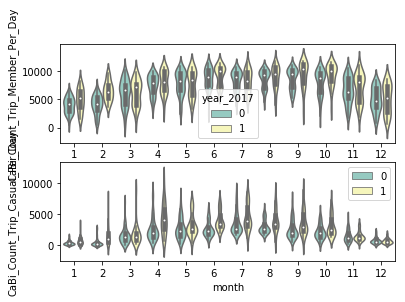

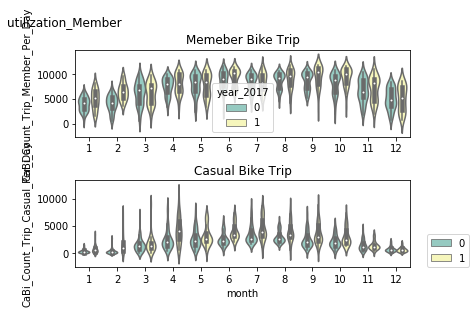

In [63]:
# Working on Comparison years / violin plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180319_184536.csv", parse_dates=column)
graph_data['utilization'] = graph_data['CaBi_Count_Trip_Per_Day']/ graph_data['CaBi_B_All']
graph_data['Pct Member'] = graph_data['CaBi_Count_Trip_Member_Per_Day'] /  graph_data['CaBi_Count_Trip_Per_Day']
graph_data_filter = graph_data[graph_data['year']>=2015 ]
graph_data_filter = pd.get_dummies(graph_data_filter,columns=['year'])

def box_me(cut, metric,axis):
    sns.violinplot(x=cut, y=metric, hue="year_2017",
                  data=graph_data_filter, palette="Set3", ax=axis, showfliers=False, figsize=(12,8))

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
box_me('month','CaBi_Count_Trip_Member_Per_Day',ax1)
box_me('month','CaBi_Count_Trip_Casual_Per_Day',ax2)

L=plt.legend()
print(L.get_texts())
L.get_texts()[0].set_text('make it short')
ax1.set_title('Memeber Bike Trip')
ax1.set_xlabel('')
ax2.set_title('Casual Bike Trip')
plt.legend(loc='best')
plt.suptitle(x, x=.1, y=1)
fig.subplots_adjust(hspace=.5)
ax2.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.show()

In [11]:
# QC - Missing days in January 23rd to 26th
# Snow Storm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180310_205606.csv", parse_dates=column)
df2 = graph_data.loc[graph_data['month']==1]
df2 = df2.loc[graph_data['year']==2016]
df2 = df2[['start_date']]
print(df2)




     start_date
1929 2016-01-01
1930 2016-01-02
1931 2016-01-03
1932 2016-01-04
1933 2016-01-05
1934 2016-01-06
1935 2016-01-07
1936 2016-01-08
1937 2016-01-09
1938 2016-01-10
1939 2016-01-11
1940 2016-01-12
1941 2016-01-13
1942 2016-01-14
1943 2016-01-15
1944 2016-01-16
1945 2016-01-17
1946 2016-01-18
1947 2016-01-19
1948 2016-01-20
1949 2016-01-21
1950 2016-01-22
1951 2016-01-27
1952 2016-01-28
1953 2016-01-29
1954 2016-01-30
1955 2016-01-31


In [36]:
# Missing days in January 23rd to 26th
# Need to Plot Hours

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

column = ['start_date']
graph_data = pd.read_csv("C:/Users/Noah/Bikeshare-DC_Old/CABI_Daily_Trips20180310_205606.csv", parse_dates=column)
df = graph_data.filter(regex="([Count_Trip_]+[0-9]+)" )
df = df.filter(regex="Count_Trip_" )
cols = df.columns.tolist()
cols_2 = cols
cols.extend(['year','month','start_date'])
hours = graph_data[cols]
print(hours.columns)


Index(['CaBi_Count_Trip_0_Hr_Per_Day', 'CaBi_Count_Trip_10_Hr_Per_Day',
       'CaBi_Count_Trip_11_Hr_Per_Day', 'CaBi_Count_Trip_12_Hr_Per_Day',
       'CaBi_Count_Trip_13_Hr_Per_Day', 'CaBi_Count_Trip_14_Hr_Per_Day',
       'CaBi_Count_Trip_15_Hr_Per_Day', 'CaBi_Count_Trip_16_Hr_Per_Day',
       'CaBi_Count_Trip_17_Hr_Per_Day', 'CaBi_Count_Trip_18_Hr_Per_Day',
       'CaBi_Count_Trip_19_Hr_Per_Day', 'CaBi_Count_Trip_1_Hr_Per_Day',
       'CaBi_Count_Trip_20_Hr_Per_Day', 'CaBi_Count_Trip_21_Hr_Per_Day',
       'CaBi_Count_Trip_22_Hr_Per_Day', 'CaBi_Count_Trip_23_Hr_Per_Day',
       'CaBi_Count_Trip_2_Hr_Per_Day', 'CaBi_Count_Trip_3_Hr_Per_Day',
       'CaBi_Count_Trip_4_Hr_Per_Day', 'CaBi_Count_Trip_5_Hr_Per_Day',
       'CaBi_Count_Trip_6_Hr_Per_Day', 'CaBi_Count_Trip_7_Hr_Per_Day',
       'CaBi_Count_Trip_8_Hr_Per_Day', 'CaBi_Count_Trip_9_Hr_Per_Day', 'year',
       'month', 'start_date'],
      dtype='object')
